In [ ]:
!pip install transformers

     |████████████████████████████████| 4.0 MB 8.7 MB/s 
     |████████████████████████████████| 6.6 MB 27.4 MB/s 
     |████████████████████████████████| 77 kB 5.4 MB/s 
     |████████████████████████████████| 895 kB 37.2 MB/s 
     |████████████████████████████████| 596 kB 44.2 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
from google.colab import drive
import os
import pandas as pd
from sklearn.multiclass import OneVsRestClassifier
from transformers import AutoTokenizer, AutoModelForMaskedLM
from tqdm import tqdm, trange
import re
from torch.utils.data import DataLoader, Dataset

drive.mount('/content/drive/')
data_path = '/content/drive/MyDrive/Colab Notebooks/Online course/data/toxic-comment-classification-challenge/'

Mounted at /content/drive/


Please download the data here: https://drive.google.com/drive/folders/1GYizuTQVGLvBpFi8fmFbAV__PW4e48Tw?usp=sharing

In [ ]:
test_file = os.path.join(data_path, 'test.csv.zip')
labels_file = os.path.join(data_path, 'test_labels.csv.zip')

In [ ]:
X_train = pd.read_csv(test_file)
y_train = pd.read_csv(labels_file)

In [ ]:
y_train.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,-1,-1,-1,-1,-1,-1


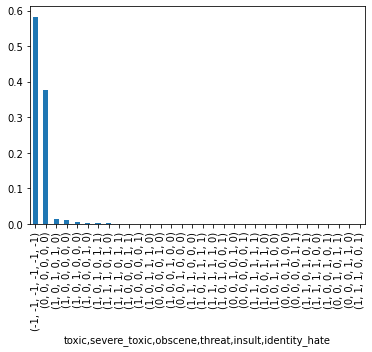

In [ ]:
y_train.set_index('id').value_counts(normalize=True).plot(kind='bar')

In [ ]:
X_train[y_train['toxic'] == 1].head()

,id,comment_text
21,00091c35fa9d0465,"== Arabs are committing genocide in Iraq, but ..."
48,0013fed3aeae76b7,DJ Robinson is gay as hell! he sucks his dick ...
59,0017d4d47894af05,":Fuck off, you anti-semitic cunt. |"
76,001d739c97bc2ae4,How dare you vandalize that page about the HMS...
81,001eff4007dbb65b,"::No, he is an arrogant, self serving, immatur..."


In [ ]:
y_train.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,-1,-1,-1,-1,-1,-1


In [ ]:
y_train.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,153164.000000,153164.000000,153164.000000,153164.000000,153164.000000,153164.000000
mean,-0.542530,-0.579895,-0.558193,-0.580913,-0.559916,-0.577642
std,0.572465,0.498408,0.542966,0.496195,0.539594,0.503260
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
50%,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

model = AutoModelForMaskedLM.from_pretrained("bert-base-uncased")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
import string
def clean_text(text):
    '''Make text lowercase, remove square brackets, links, punctuation
    and numbers.'''
    text = text.lower()
    
    #all characters in square brackets 
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('<.*?>+', '', text)

    #web address
    text = re.sub('https?://\S+|www\.\S+', '', text)
    
    #punctionation
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    
    #new line
    text = re.sub('\n', '', text)
    
    #non characters
    text = re.sub('\w*\d\w*', '', text)
    return text

In [ ]:
X_train['comment_text'] = X_train['comment_text'].apply(clean_text)

In [ ]:
X_train['comment_text']

0         yo bitch ja rule is more succesful then youll ...
1                 from rfc   the title is fine as it is imo
2                   sources    zawe ashton on lapland —    
3         if you have a look back at the source the info...
4                   i dont anonymously edit articles at all
                                ...                        
153159      i totally agree this stuff is nothing but to...
153160     throw from out field to home plate   does it ...
153161       okinotorishima categories   i see your chan...
153162       one of the founding nations of the eu  germ...
153163      stop already your bullshit is not welcome he...
Name: comment_text, Length: 153164, dtype: object

In [ ]:
senten_len = []
train_batch = 32
valid_batch = 32

for sentence in tqdm(X_train['comment_text']):
    token_words = tokenizer.encode_plus(sentence)['input_ids']
    senten_len.append(len(token_words))


train_dataloader = DataLoader(X_train, batch_size = train_batch, pin_memory = True, num_workers = 4, shuffle = True)

100%|██████████| 153164/153164 [00:42<00:00, 3603.07it/s]
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


# Exercize

use BERT to get the vectors.

# Retrainig part of the model


amp stands for automatic mixed precision.
To learn more about the autocast read this link:
https://pytorch.org/docs/stable/amp.html
in short: Instances of autocast serve as context managers or decorators that allow regions of your script to run in mixed precision, where some operations use the torch.float32 (float) datatype and other operations use torch.float16 (half). autocast should wrap only the forward pass(es) of your network, including the loss computation(s). Backward passes under autocast are not recommended.

with statement in Python is used in exception handling to make the code cleaner and much more readable. It simplifies the management of common resources like file streams. Here is a link to learn more about it.
https://www.geeksforgeeks.org/with-statement-in-python/

Non-Blocking allows you to overlap compute and memory transfer to the GPU. Pinned Memory allows the non-blocking calls to actually be non-blocking.

Why using var.detach().cpu().numpy() and not var.numpy() only?
because we get an error. The main reason behind this choice presumably is to avoid confusing new comers. People not very familiar with requires_grad and cpu/gpu Tensors might go back and forth with numpy. For example doing pytorch -> numpy -> pytorch and backward on the last Tensor. This will backward without issue but not all the way to the first part of the code and won’t raise any error. So the choice has been made to force the user to detach() to make sure they want to do it and it’s not a typo/other library that does this tranformation and breaks the computational graph.

optimizer.step(): it performs a parameter update based on the current gradient (stored in .grad attribute of a parameter) and the update rule. As an example, the update rule for SGD is defined here:
https://github.com/pytorch/pytorch/blob/cd9b27231b51633e76e28b6a34002ab83b0660fc/torch/optim/sgd.py#L63

loss.backward() Calling .backward() mutiple times accumulates the gradient (by addition) for each parameter. This is why you should call optimizer.zero_grad() after each .step() call. Note that following the first .backward call, a second call is only possible after you have performed another forward pass.

Gradient Scaling
If the forward pass for a particular op has float16 inputs, the backward pass for that op will produce float16 gradients. Gradient values with small magnitudes may not be representable in float16. These values will flush to zero (“underflow”), so the update for the corresponding parameters will be lost.

To prevent underflow, “gradient scaling” multiplies the network’s loss(es) by a scale factor and invokes a backward pass on the scaled loss(es). Gradients flowing backward through the network are then scaled by the same factor. In other words, gradient values have a larger magnitude, so they don’t flush to zero.

Each parameter’s gradient (.grad attribute) should be unscaled before the optimizer updates the parameters, so the scale factor does not interfere with the learning rate.

step() carries out the following two operations:

Internally invokes unscale(optimizer) (unless unscale() was explicitly called for optimizer earlier in the iteration). As part of the unscale_(), gradients are checked for infs/NaNs.
If no inf/NaN gradients are found, invokes optimizer.step() using the unscaled gradients. Otherwise, optimizer.step() is skipped to avoid corrupting the params.

In [ ]:
def training(train_dataloader, model, optimizer, scheduler):
    model.train()
    torch.backends.cudnn.benchmark = True
    correct_predictions = 0
    
    for a in train_dataloader:
        losses = []
        optimizer.zero_grad()
        
        with torch.cuda.amp.autocast():
            
            ids = a['ids'].to(device, non_blocking = True)
            mask = a['mask'].to(device, non_blocking = True) 

            output = model(ids, mask) #This gives model as output, however we want the values at the output
            output = output['logits'].squeeze(-1).to(torch.float32)

            output_probs = torch.sigmoid(output)
            preds = torch.where(output_probs > 0.5, 1, 0)
            
            toxic_label = a['toxic_label'].to(device, non_blocking = True) 
            loss = loss_fn(output, toxic_label)            
            
            losses.append(loss.item())
            #allpreds.append(output.detach().cpu().numpy())
            #alltargets.append(toxic.detach().squeeze(-1).cpu().numpy())
            correct_predictions += torch.sum(preds == toxic_label)
        
        scaler.scale(loss).backward() #Multiplies (‘scales’) a tensor or list of tensors by the scale factor.
                                      #Returns scaled outputs. If this instance of GradScaler is not enabled, outputs are returned unmodified.
        scaler.step(optimizer) #Returns the return value of optimizer.step(*args, **kwargs).
        scaler.update() #Updates the scale factor.If any optimizer steps were skipped the scale is multiplied by backoff_factor to reduce it. 
                        #If growth_interval unskipped iterations occurred consecutively, the scale is multiplied by growth_factor to increase it
        scheduler.step() # Update learning rate schedule
    
    losses = np.mean(losses)
    corr_preds = correct_predictions.detach().cpu().numpy()
    accuracy = corr_preds/(len(k_train)*6)
    
    return losses, accuracy

In [ ]:
import numpy as np
import pandas as pd
import os
import random
import time

import re
import string
import nltk
from nltk.corpus import stopwords

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks", context="talk")
plt.style.use('dark_background')

from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as func
from torch.utils.data import DataLoader, Dataset

import transformers
from transformers import AdamW, get_linear_schedule_with_warmup

import tokenizers
from sklearn.metrics import mean_squared_error, roc_auc_score, roc_curve, auc

import warnings
warnings.simplefilter('ignore')


SEED = 11
def random_seed(SEED):
    random.seed(SEED)
    os.environ['PYTHONHASHSEED'] = str(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
random_seed(SEED)

max_len = 200

class BertDataSet(Dataset):
    
    def __init__(self, sentences, toxic_labels):
        self.sentences = sentences
        #target is a matrix with shape [#1 x #6(toxic, obscene, etc)]
        self.targets = toxic_labels.to_numpy()
    
    def __len__(self):
        return len(self.sentences)
    
    
    def __getitem__(self, idx):
        sentence = self.sentences[idx]
        bert_senten = tokenizer.encode_plus(sentence, 
                                            add_special_tokens = True, # [CLS],[SEP]
                                            max_length = max_len,
                                            pad_to_max_length = True,
                                            truncation = True,
                                            return_attention_mask = True
                                             )
        ids = torch.tensor(bert_senten['input_ids'], dtype = torch.long)
        mask = torch.tensor(bert_senten['attention_mask'], dtype = torch.long)
        toxic_label = torch.tensor(self.targets[idx], dtype = torch.float)
        
        
        return {
            'ids' : ids,
            'mask' : mask,
            'toxic_label':toxic_label
        }

epochs = 5
train_batch = 32
valid_batch = 32
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

loss_fn = nn.BCEWithLogitsLoss()
loss_fn.to(device)
scaler = torch.cuda.amp.GradScaler()

def training(train_dataloader, model, optimizer, scheduler):
    model.train()
    torch.backends.cudnn.benchmark = True
    correct_predictions = 0
    
    for a in train_dataloader:
        losses = []
        optimizer.zero_grad()
        
        #allpreds = []
        #alltargets = []
        
        with torch.cuda.amp.autocast():
            
            ids = a['ids'].to(device, non_blocking = True)
            mask = a['mask'].to(device, non_blocking = True) 

            output = model(ids, mask) #This gives model as output, however we want the values at the output
            output = output['logits'].squeeze(-1).to(torch.float32)

            output_probs = torch.sigmoid(output)
            preds = torch.where(output_probs > 0.5, 1, 0)
            
            toxic_label = a['toxic_label'].to(device, non_blocking = True) 
            loss = loss_fn(output, toxic_label)            
            
            losses.append(loss.item())
            #allpreds.append(output.detach().cpu().numpy())
            #alltargets.append(toxic.detach().squeeze(-1).cpu().numpy())
            correct_predictions += torch.sum(preds == toxic_label)
        
        scaler.scale(loss).backward() #Multiplies (‘scales’) a tensor or list of tensors by the scale factor.
                                      #Returns scaled outputs. If this instance of GradScaler is not enabled, outputs are returned unmodified.
        scaler.step(optimizer) #Returns the return value of optimizer.step(*args, **kwargs).
        scaler.update() #Updates the scale factor.If any optimizer steps were skipped the scale is multiplied by backoff_factor to reduce it. 
                        #If growth_interval unskipped iterations occurred consecutively, the scale is multiplied by growth_factor to increase it
        scheduler.step() # Update learning rate schedule
    
    losses = np.mean(losses)
    corr_preds = correct_predictions.detach().cpu().numpy()
    accuracy = corr_preds/(len(k_train)*6)
    
    return losses, accuracy

def validating(valid_dataloader, model):
    
    model.eval()
    correct_predictions = 0
    all_output_probs = []
    
    for a in valid_dataloader:
        losses = []
        ids = a['ids'].to(device, non_blocking = True)
        mask = a['mask'].to(device, non_blocking = True)
        output = model(ids, mask)
        output = output['logits'].squeeze(-1).to(torch.float32)
        output_probs = torch.sigmoid(output)
        preds = torch.where(output_probs > 0.5, 1, 0)
            
        toxic_label = a['toxic_label'].to(device, non_blocking = True)
        loss = loss_fn(output, toxic_label)
        losses.append(loss.item())
        all_output_probs.extend(output_probs.detach().cpu().numpy())
        
        correct_predictions += torch.sum(preds == toxic_label)
        corr_preds = correct_predictions.detach().cpu().numpy()
    
    losses = np.mean(losses)
    corr_preds = correct_predictions.detach().cpu().numpy()
    accuracy = corr_preds/(len(p_valid)*6)
    
    return losses, accuracy, all_output_probs

# Validating function
validating function is quite similar to training function. The difference is that there is no back-propagation and optemization for parameters in it.

In [ ]:
def validating(valid_dataloader, model):
    
    model.eval()
    correct_predictions = 0
    all_output_probs = []
    
    for a in valid_dataloader:
        losses = []
        ids = a['ids'].to(device, non_blocking = True)
        mask = a['mask'].to(device, non_blocking = True)
        output = model(ids, mask)
        output = output['logits'].squeeze(-1).to(torch.float32)
        output_probs = torch.sigmoid(output)
        preds = torch.where(output_probs > 0.5, 1, 0)
            
        toxic_label = a['toxic_label'].to(device, non_blocking = True)
        loss = loss_fn(output, toxic_label)
        losses.append(loss.item())
        all_output_probs.extend(output_probs.detach().cpu().numpy())
        
        correct_predictions += torch.sum(preds == toxic_label)
        corr_preds = correct_predictions.detach().cpu().numpy()
    
    losses = np.mean(losses)
    corr_preds = correct_predictions.detach().cpu().numpy()
    accuracy = corr_preds/(len(p_valid)*6)
    
    return losses, accuracy, all_output_probs

# Training

In [ ]:
kfold = 3
X_train['kfold'] = X_train.index % kfold
p_valid = X_train[X_train["kfold"] == 0].reset_index(drop = True)
k_train = X_train[X_train["kfold"] != 0].reset_index(drop = True)


In [ ]:
epochs = 100
best_score = 1000
train_accs = []
valid_accs = []
train_losses = []
valid_losses = []
LR = 2e-5
optimizer = AdamW(model.parameters(), LR,betas = (0.9, 0.999), weight_decay = 1e-2) # AdamW optimizer
train_steps = int(len(k_train)/train_batch * epochs)
num_steps = int(train_steps * 0.1)

scheduler = get_linear_schedule_with_warmup(optimizer, num_steps, train_steps)

for eboch in tqdm(range(epochs)):
    
    train_loss, train_acc = training(train_dataloader, model, optimizer, scheduler)
    valid_loss, valid_acc, valid_probs = validating(valid_dataloader, model)
    
    print('train losses: %.4f' % train_loss, 'train accuracy: %.3f' % train_acc)
    print('valid losses: %.4f' % valid_loss, 'valid accuracy: %.3f' % valid_acc)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accs.append(train_acc)
    valid_accs.append(valid_acc)
    
    
    if valid_loss < best_score:
        best_score = valid_loss
        print('Found a good model!')
        state = {
            'state_dict': model.state_dict(),
            'optimizer_dict': optimizer.state_dict(),
            'best_score': best_score
        }
        torch.save(state, 'best_model.pth')
    else:
        pass

  0%|          | 0/100 [00:00<?, ?it/s]


KeyError: ignored

# Results

In [ ]:
x = np.arange(epochs)
fig, ax = plt.subplots(1, 2, figsize = (15,4))
ax[0].plot(x, train_losses)
ax[0].plot(x, valid_losses)
ax[0].set_ylabel('Losses', weight = 'bold')
ax[0].set_xlabel('Epochs')
ax[0].grid(alpha = 0.3)
ax[0].legend(labels = ['train losses', 'valid losses'])

ax[1].plot(x, train_accs)
ax[1].plot(x, valid_accs)
ax[1].set_ylabel('Accuracy', weight = 'bold')
ax[1].set_xlabel('Epochs')
ax[1].legend(labels = ['train acc', 'valid acc'])

ax[1].grid(alpha = 0.3)
fig.suptitle('Fold = 0', weight = 'bold') 